# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 1 - Atomistic simulations with [pyiron](https://pyiron.org)**


### **Exercise 1: Introduction to atomistic simulations with pyiron**

Before the excercise, you should:

* Be familiar with python especially with numerical libraries like numpy and plotting tools like matplotlib
* Understand how Jupyter Notebooks work

The aim of this exercise is to make you familiar with:

* A general overview of what pyiron can do
* How to set up atomic structures and run atomistic simulation codes through pyiron

### **Importing necessary libraries**

As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [2]:
from pyiron import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

### **Creation of a project instance**

In [3]:
pr = Project("first_steps")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [4]:
pr.path

'/home/surendralal/notebooks/pyiron_potentialfit/day_1/first_steps/'

In [5]:
pr

{'groups': ['E_V_curve', 'E_V_curve_DFT'], 'nodes': ['lammps_job', 'sphinx_job']}

### **Creating atomic structures**

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

In [6]:
# Creating a bulk fcc cubic unitcell
Cu_unitcell_cubic = pr.create_ase_bulk('Cu', cubic=True, a=3.61)
Cu_unitcell_cubic

Cu: [0. 0. 0.]
Cu: [0.    1.805 1.805]
Cu: [1.805 0.    1.805]
Cu: [1.805 1.805 0.   ]
pbc: [ True  True  True]
cell: 
Cell([3.61, 3.61, 3.61])

In [7]:
Cu_supercell_3_3_3 = Cu_unitcell_cubic.repeat([3, 3, 3])
Cu_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

In [8]:
# Creating a bulk fcc primitive unitcell and cupercell
Cu_unitcell_primitive = pr.create_ase_bulk('Cu', a=4.01)
Cu_unitcell_primitive.repeat([3, 3, 3]).plot3d(particle_size=2)

NGLWidget()

In [9]:
# Creating a vacancy in a supercell
Cu_vacancy = Cu_supercell_3_3_3.copy()
del Cu_vacancy[0] # Deleting the first atom
print(Cu_supercell_3_3_3.get_chemical_formula(), Cu_vacancy.get_chemical_formula())
Cu_vacancy.plot3d(particle_size=2)

Cu108 Cu107


NGLWidget()

In [10]:
# Creating a fcc111 surface supercell
num_layers = 4
Cu_fcc_111 = pr.create_surface("Cu", surface_type="fcc111", size=(4, 4, num_layers), vacuum=12, orthogonal=True)
Cu_fcc_111.plot3d(particle_size=2)

NGLWidget()

In [11]:
# Atom in a box
cell = np.eye(3) * 10
Cu_atom_box = pr.create_atoms("Cu", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Cu_atom_box.plot3d(particle_size=2)

NGLWidget()

In [12]:
# Cu-Cu dimer
cell = np.eye(3) * 10
Cu_atom_1 = pr.create_atoms("Cu", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Cu_atom_2 = Cu_atom_1.copy()

dimer_length = 2.5
Cu_atom_2.positions[:, 2] += dimer_length
Cu_dimer = Cu_atom_1 + Cu_atom_2
Cu_dimer.center()
Cu_dimer.plot3d()

NGLWidget()

### **Running an atomistic calculation using interatomic potentials (with LAMMPS)**

Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [13]:
# Create a job
job_lammps = pr.create.job.Lammps(job_name="lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Cu supercell structure we created earlier

In [14]:
# Assign an atomic structure to the job
job_lammps.structure = Cu_supercell_3_3_3

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Cu can be found below

In [15]:
# See available potentials
job_lammps.list_potentials()[50:60]

['EAM_Dynamo_LiuLiuBorucki_1999_AlCu__MO_020851069572_000',
 'EAM_Dynamo_MendelevKing_2008_Cu__MO_748636486270_005',
 'EAM_Dynamo_MendelevKramerBecker_2008_Cu__MO_945691923444_005',
 'EAM_Dynamo_MendelevKramerOtt_2009_CuZr__MO_600021860456_005',
 'EAM_Dynamo_MendelevSordeletKramer_2007_CuZr__MO_120596890176_005',
 'EAM_Dynamo_MishinMehlPapaconstantopoulos_2001_Cu__MO_346334655118_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EAM_Dynamo_WilliamsMishinHamilton_2006_CuAg__MO_128703483589_005',
 'EAM_Dynamo_WuTrinkle_2009_CuAg__MO_270337113239_005',
 'EAM_Dynamo_ZhouJohnsonWadley_2004NISTretabulation_CuAgAu__MO_318213562153_000']

In [16]:
# Choose one of these potentials
job_lammps.potential = '2012--Mendelev-M-I--Cu--LAMMPS--ipr1'

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [17]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

We can now see how pyiron sets-up the corresponding LAMMPS input

In [18]:
job_lammps.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 800.0 800.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [19]:
job_lammps.run()

2021-03-08 11:13:25,652 - pyiron_log - WARNING - The job lammps_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [20]:
pr

{'groups': ['E_V_curve', 'E_V_curve_DFT'], 'nodes': ['lammps_job', 'sphinx_job']}

In [21]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,4354,finished,Cu108,lammps_job,/lammps_job,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/,2021-03-06 16:03:40.745470,2021-03-06 16:03:45.494803,4.0,pyiron@cmdell17#1,Lammps,0.1,None,None
1,4355,finished,Cu,sphinx_job,/sphinx_job,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/,2021-03-06 16:04:50.074383,2021-03-06 16:04:56.638128,6.0,pyiron@cmdell17#1,Sphinx,2.6.1,None,None
2,4356,finished,Cu,job_a_3_4,/job_a_3_4,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:07.639631,2021-03-06 16:11:08.342303,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
3,4357,finished,Cu,job_a_3_5,/job_a_3_5,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:08.822636,2021-03-06 16:11:09.471384,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
4,4358,finished,Cu,job_a_3_6,/job_a_3_6,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:09.943131,2021-03-06 16:11:10.600866,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
5,4359,finished,Cu,job_a_3_7,/job_a_3_7,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:11.080672,2021-03-06 16:11:11.753735,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
6,4360,finished,Cu,job_a_3_8,/job_a_3_8,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:12.228943,2021-03-06 16:11:12.867039,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
7,4361,finished,Cu,job_a_3_9,/job_a_3_9,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:13.342478,2021-03-06 16:11:13.979644,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
8,4362,finished,Cu,job_a_4_0,/job_a_4_0,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:14.465906,2021-03-06 16:11:15.082557,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
9,4363,finished,Cu,job_a_3_4,/job_a_3_4,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve_DFT/,2021-03-06 16:13:46.540931,2021-03-06 16:13:49.880940,3.0,pyiron@cmdell17#1,Sphinx,2.6.1,None,None


## Analysing a calculation

In [22]:
%%time
# Load the job
job_loaded = pr['lammps_job']

CPU times: user 1.14 s, sys: 406 ms, total: 1.55 s
Wall time: 1.54 s


In [23]:
job_loaded


{'groups': ['input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [24]:
job_loaded["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

In [25]:
final_struct = job_loaded.get_structure(iteration_step=-1)
final_struct.plot3d()

NGLWidget()

In [26]:
job_loaded.animate_structure()

NGLWidget(max_frame=100)

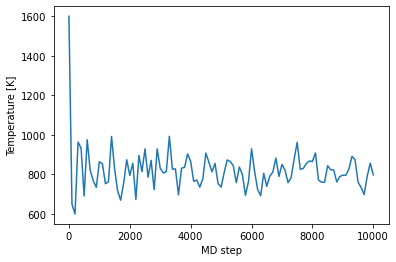

In [27]:
temperatures = job_loaded['output/generic/temperature']
steps = job_loaded['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

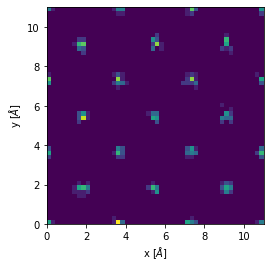

In [28]:
pos = job_loaded['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.1
fig, axs = plt.subplots(1,1)
axs.hist2d(x[sel], y[sel], bins=50)
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box');

### **Running an atomistic calculation using DFT (with SPHInX)**

In [29]:
job_sphinx = pr.create.job.Sphinx("sphinx_job")
job_sphinx.structure = Cu_unitcell_primitive
job_sphinx.set_exchange_correlation_functional("PBE")
job_sphinx.plane_wave_cutoff = 350
job_sphinx.calc_static()
job_sphinx.run()

/home/surendralal/programs/pyiron_base/pyiron_base/generic/inputlist.py:323: UserWarning: The input in Group changed, while the state of the job was already finished.
  warnings.warn(
2021-03-08 11:16:38,598 - pyiron_log - WARNING - The job sphinx_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [30]:
job_sphinx['output/generic/']

{'groups': ['dft'], 'nodes': ['cells', 'computation_time', 'energy_pot', 'energy_tot', 'forces', 'positions', 'volume']}

In [31]:
job_sphinx["output/generic/energy_tot"] # Energy for every ionic step

array([-5386.42735597])

In [32]:
job_sphinx['output/electronic_structure']

{'groups': ['dos'], 'nodes': ['TYPE', 'efermi', 'eig_matrix', 'k_points', 'k_weights', 'occ_matrix']}

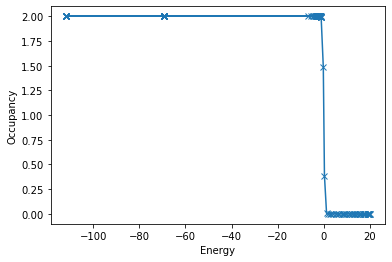

In [33]:
eigenvalues = job_sphinx['output/electronic_structure/eig_matrix'].flatten()
occupancies = job_sphinx['output/electronic_structure/occ_matrix'].flatten()

efermi = job_sphinx['output/electronic_structure/efermi']
args = np.argsort(occupancies)
plt.plot(eigenvalues[args] -efermi, occupancies[args], "-x")
plt.xlabel('Energy')
plt.ylabel('Occupancy');

## **Task 1: Energy volume curve for Al**

In [34]:
def get_volume(job):
    return job["output/generic/volume"][-1]

In [35]:
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

In [36]:
get_energy(job_loaded), get_volume(job_loaded)

(-345.776978906969, 1337.89883611173)

In [37]:
%%time
pr_ev = pr.create_group("E_V_curve") # Creating a new sub-project within the main project
a_list = np.linspace(3.4, 4.0, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Lammps(job_name)
    job.structure = pr_ev.create_ase_bulk("Cu", a=a)
    job.potential = '2012--Mendelev-M-I--Cu--LAMMPS--ipr1'
    job.calc_minimize()
    job.run()
    

2021-03-08 11:19:23,879 - pyiron_log - WARNING - The job job_a_3_4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:26,309 - pyiron_log - WARNING - The job job_a_3_5 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:29,036 - pyiron_log - WARNING - The job job_a_3_6 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:31,081 - pyiron_log - WARNING - The job job_a_3_7 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:33,948 - pyiron_log - WARNING - The job job_a_3_8 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:36,713 - pyiron_log - WARNING - The job job_a_3_9 is being loaded instead of running. To re-run use the argument 'delete_existin

CPU times: user 14.2 s, sys: 6.02 s, total: 20.2 s
Wall time: 16.5 s


In [38]:
pr.list_groups(), pr.list_nodes()

(['E_V_curve', 'E_V_curve_DFT'], ['lammps_job', 'sphinx_job'])

In [39]:
pr_ev.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,4356,finished,Cu,job_a_3_4,/job_a_3_4,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:07.639631,2021-03-06 16:11:08.342303,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
1,4357,finished,Cu,job_a_3_5,/job_a_3_5,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:08.822636,2021-03-06 16:11:09.471384,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
2,4358,finished,Cu,job_a_3_6,/job_a_3_6,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:09.943131,2021-03-06 16:11:10.600866,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
3,4359,finished,Cu,job_a_3_7,/job_a_3_7,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:11.080672,2021-03-06 16:11:11.753735,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
4,4360,finished,Cu,job_a_3_8,/job_a_3_8,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:12.228943,2021-03-06 16:11:12.867039,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
5,4361,finished,Cu,job_a_3_9,/job_a_3_9,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:13.342478,2021-03-06 16:11:13.979644,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None
6,4362,finished,Cu,job_a_4_0,/job_a_4_0,/home/surendralal/,notebooks/pyiron_potentialfit/day_1/first_steps/E_V_curve/,2021-03-06 16:11:14.465906,2021-03-06 16:11:15.082557,0.0,pyiron@cmdell17#1,Lammps,0.1,None,None


CPU times: user 7.06 s, sys: 2.73 s, total: 9.8 s
Wall time: 8.18 s


Text(0, 0.5, 'Energy [eV]')

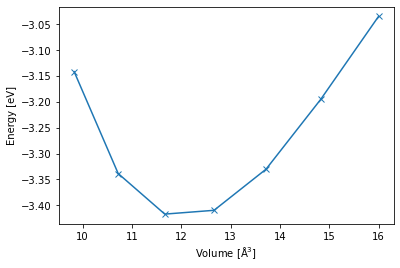

In [40]:
%%time
# Analysing the data
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

CPU times: user 250 ms, sys: 46.9 ms, total: 297 ms
Wall time: 322 ms


Text(0, 0.5, 'Energy [eV]')

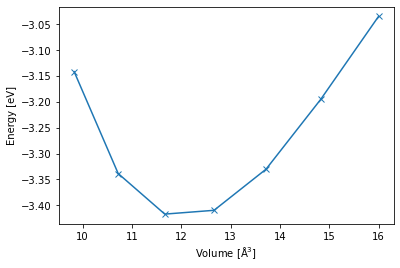

In [41]:
%%time
# Analysing the data
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(convert_to_object=False, status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

## **Task 2: E-V curves for DFT**

In [42]:
%%time
pr_ev = pr.create_group("E_V_curve_DFT") # Creating a new sub-project within the main project
a_list = np.linspace(3.4, 4.0, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Sphinx(job_name)
    job.structure = pr_ev.create_ase_bulk("Cu", a=a)
    job.set_exchange_correlation_functional("PBE")
    job.plane_wave_cutoff = 350
    job.set_kpoints(mesh=[4, 4, 4])
    job.set_occupancy_smearing("fermi", 0.1)
    job.calc_minimize()
    job.run()
    

/home/surendralal/programs/pyiron_base/pyiron_base/generic/inputlist.py:323: UserWarning: The input in Group changed, while the state of the job was already finished.
  warnings.warn(
2021-03-08 11:19:50,455 - pyiron_log - WARNING - The job job_a_3_4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:51,968 - pyiron_log - WARNING - The job job_a_3_5 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:54,008 - pyiron_log - WARNING - The job job_a_3_6 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:55,854 - pyiron_log - WARNING - The job job_a_3_7 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:19:57,682 - pyiron_log - WARNING - The job job_a_3_8 is being loaded instead of running. To re-run use the argument 'd

CPU times: user 9.27 s, sys: 2.62 s, total: 11.9 s
Wall time: 12.1 s


CPU times: user 531 ms, sys: 125 ms, total: 656 ms
Wall time: 696 ms


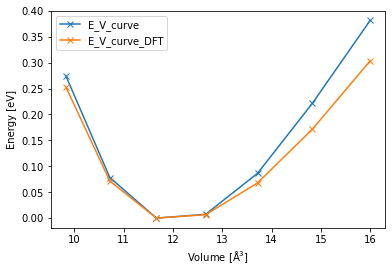

In [43]:
%%time
# Analysing the data
group_list = pr.list_groups()

for group in group_list:
    vol_list = list()
    energy_list = list()
    for job in pr[group].iter_jobs(convert_to_object=False, status="finished"):
        vol_list.append(get_volume(job))
        energy_list.append(get_energy(job))
    args = np.argsort(vol_list)
    vol_list = np.array(vol_list)
    energy_list = np.array(energy_list)
    plt.plot(vol_list[args], energy_list[args] - np.min(energy_list), "-x", label=group)
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]")
plt.legend();

## **Advanced pyiron: Automated workflows and analysis tools**

In [44]:
num_pot = 3
pot_finder = pr.inspect_emperical_potentials()
pot_list = pot_finder.find("Cu").Name.to_list()[:num_pot]
pot_list

['Cu_Mendelev_eam',
 '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1']

In [45]:
def clean_project_name(name):
    return name.replace("-", "_")

In [46]:
%%time
# Automated Murnaghan
# pyiron tables

pr_murn = Project("murn_auto") 

for pot in pot_list:
    
    lammps_job = pr_murn.create.job.Lammps("lammps_ref")
    lammps_job.structure = pr.create_ase_bulk("Cu")
    lammps_job.potential = pot
    lammps_job.calc_minimize()
    
    # Creating a Murnaghan workflow (char names not to exceed 50 chars)
    job_name = "murn_ref_{}".format(clean_project_name(pot))[:40]
    
    murn_job = lammps_job.create_job(pr.job_type.Murnaghan, job_name)
    murn_job.input["num_points"] = 9
    murn_job.run()

2021-03-08 11:20:04,503 - pyiron_log - WARNING - The job murn_ref_Cu_Mendelev_eam is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:20:06,613 - pyiron_log - WARNING - The job murn_ref_2004__Zhou_X_W__Cu_Ag_Au__LAMMP is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-03-08 11:20:09,169 - pyiron_log - WARNING - The job murn_ref_1985__Foiles_S_M__Ni_Cu__LAMMPS is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


CPU times: user 5.44 s, sys: 2.2 s, total: 7.64 s
Wall time: 6.29 s


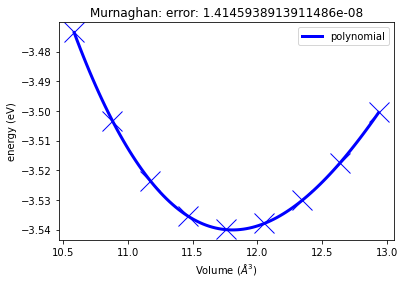

In [47]:
murn_job.plot()

In [48]:
murn_job["output/equilibrium_volume"], murn_job["output/equilibrium_bulk_modulus"]

(11.808803921590759, 141.83475481259447)

In [49]:
np.linalg.norm(murn_job["output/structure/cell/cell"][0]) * np.sqrt(2)

3.614836295562474

In [50]:
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished")

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

In [51]:
%%time
table = pr_murn.create.table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm

table.run()
table.get_dataframe()

  0%|          | 0/5 [00:00<?, ?it/s]

The job table_murn was saved and received the ID: 4370


100%|██████████| 5/5 [00:00<00:00, 24.24it/s]


CPU times: user 406 ms, sys: 156 ms, total: 562 ms
Wall time: 608 ms


,job_id,a,eq_vol,eq_bm
0,3723,3.637366,12.030984,152.193869
1,3733,3.614933,11.809748,135.833772
2,3743,3.614836,11.808804,141.834755
3,4308,3.614933,11.809748,135.833772
4,4318,3.614836,11.808804,141.834755
